# INF-0616 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br 

Este notebook faz parte da disciplina INF-0616 no curso de extensão MDC.
Demais artefatos podem ser encontrados no moodle da disciplina: moodle.lab.ic.unicamp.br/469

Instituto de Computação - Unicamp 2022

#### **Integrantes do grupo**

- Nome: Leonardo Cesar Silva dos Santos
- Nome: Fernando Augusto Cardoso Candalaft

In [1]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns


from IPython.display import display

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas a um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
train = pd.read_csv('./doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

In [3]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,"BDS, MDS - Conservative Dentistry & Endodontics",6 years experience,NaN,"Nungambakkam, Chennai",Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,MBBS,9 years experience,NaN,"Balapur, Hyderabad",General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,"MD - Dermatology , Venereology & Leprosy, MBBS",17 years experience,NaN,"Manikonda, Hyderabad",Dermatologists,NaN,350
1992,BAMS,10 years experience,100%,"Konanakunte, Bangalore",Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,BHMS,0 years experience,NaN,"Vidyanagar, Hyderabad",Homeopath,NaN,200


#### Pré-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [4]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [5]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,"bds, mds - conservative dentistry & endodontics",6.0,NaN,"nungambakkam, chennai",Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,"balapur, hyderabad",General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,"md - dermatology , venereology & leprosy, mbbs",17.0,NaN,"manikonda, hyderabad",Dermatologists,NaN,350
1992,bams,10.0,1.0,"konanakunte, bangalore",Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,"vidyanagar, hyderabad",Homeopath,NaN,200


In [6]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [7]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,"bds, mds - conservative dentistry & endodontics",6.0,NaN,"nungambakkam, chennai",Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,"balapur, hyderabad",General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,"md - dermatology , venereology & leprosy, mbbs",17.0,NaN,"manikonda, hyderabad",Dermatologists,NaN,350
1992,bams,10.0,1.0,"konanakunte, bangalore",Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,"vidyanagar, hyderabad",Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [8]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(x=labels[:showing], y=counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)
/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)


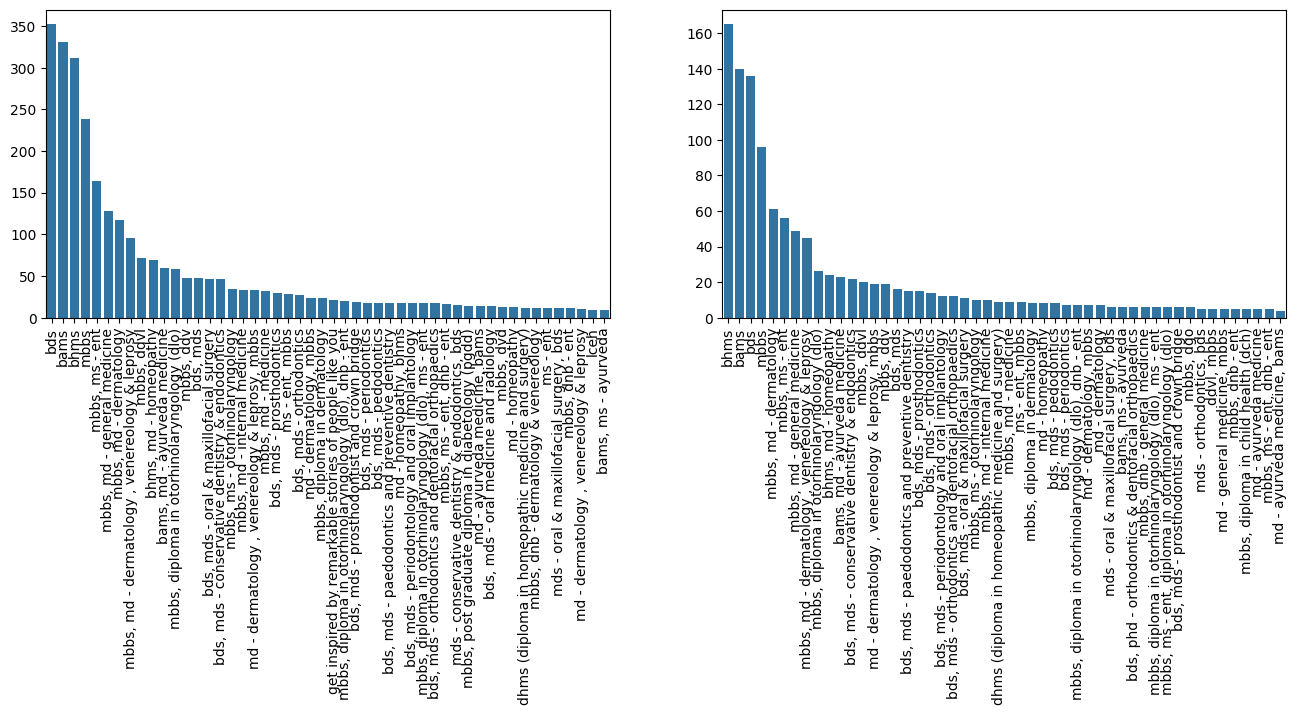

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)
/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)


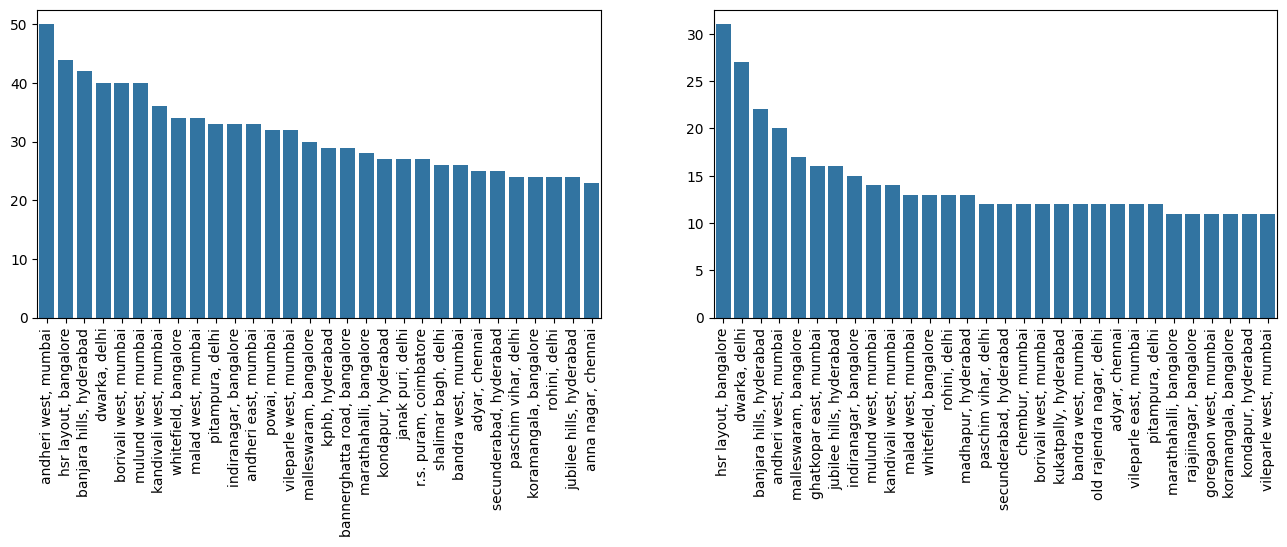

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)
/tmp/ipykernel_5537/1048264245.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels[:showing], rotation=90)


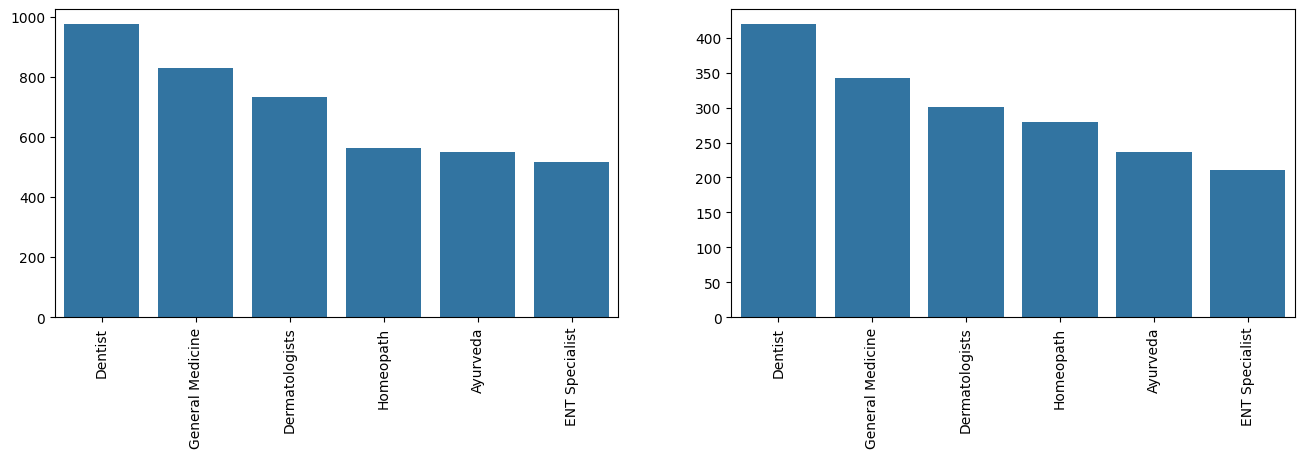

In [11]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [13]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Substituímos as células desconhecidas pelo valor mediano e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [14]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [15]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
# Apesar da normalização ser imprescindível, 
# ela está acontecendo no conjunto de teste com os parâmetros 
# que encontramos no conjunto de treino. 
# Logo, não estamos usando informação do teste, mas apenas adequando a
# faixa de valores para a faixa com a qual o modelo foi treinado.
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

In [16]:
ye_train

array([ 1.00909032, -0.03906913,  0.22297073, ..., -0.30110899,
       -0.03906913, -0.82518872])

**Atividade (3 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaram a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSerach, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [17]:
np.random.seed(1082141)
sns.set()

In [21]:
train_e.toarray().shape

(4171, 208)

In [24]:
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [61]:
import os

os.cpu_count()

n_jobs = os.cpu_count() - 2

n_jobs

6

In [68]:
kernel_range = ["linear", "rbf"] # "poly", "sigmoid"
C_range = np.logspace(-2, 5, 5)
epsilon_range = np.logspace(start=-2, stop=2, num=5)

param_grid = dict(C=C_range, kernel=kernel_range, epsilon=epsilon_range)

svr = SVR(max_iter=100000)

param_grid

{'C': array([1.00000000e-02, 5.62341325e-01, 3.16227766e+01, 1.77827941e+03,
        1.00000000e+05]),
 'kernel': ['linear', 'rbf'],
 'epsilon': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}

In [69]:
5 * 2 * 5 * 5 * 5

1250

In [70]:
grid = GridSearchCV(svr, 
                    param_grid, 
                    cv=5, 
                    scoring="neg_mean_squared_error",
                    verbose=3, 
                    n_jobs=n_jobs)

grid.fit(train_e, ye_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5] END C=0.01, epsilon=0.01, kernel=linear;, score=-0.827 total time=   0.9s
[CV 5/5] END C=0.01, epsilon=0.01, kernel=linear;, score=-0.933 total time=   1.0s
[CV 1/5] END C=0.01, epsilon=0.01, kernel=linear;, score=-0.867 total time=   1.0s
[CV 4/5] END C=0.01, epsilon=0.01, kernel=linear;, score=-0.947 total time=   1.1s
[CV 3/5] END C=0.01, epsilon=0.01, kernel=linear;, score=-0.910 total time=   1.1s
[CV 1/5] END .C=0.01, epsilon=0.01, kernel=rbf;, score=-0.892 total time=   1.6s
[CV 2/5] END .C=0.01, epsilon=0.01, kernel=rbf;, score=-0.875 total time=   1.3s
[CV 1/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.863 total time=   1.1s
[CV 5/5] END .C=0.01, epsilon=0.01, kernel=rbf;, score=-0.979 total time=   1.3s
[CV 2/5] END C=0.01, epsilon=0.1, kernel=linear;, score=-0.828 total time=   0.8s[CV 3/5] END .C=0.01, epsilon=0.01, kernel=rbf;, score=-0.952 total time=   1.4s

[CV 4/5] END .C=0.01, epsilon=0.01,

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=31.622776601683793, epsilon=0.01, kernel=linear;, score=-0.951 total time=  12.6s
[CV 3/5] END C=31.622776601683793, epsilon=0.01, kernel=linear;, score=-0.941 total time=  13.1s
[CV 1/5] END C=31.622776601683793, epsilon=0.01, kernel=linear;, score=-0.940 total time=  13.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=31.622776601683793, epsilon=0.01, kernel=linear;, score=-0.786 total time=  13.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=31.622776601683793, epsilon=0.01, kernel=linear;, score=-0.959 total time=  14.4s
[CV 3/5] END C=31.622776601683793, epsilon=0.01, kernel=rbf;, score=-1.074 total time=   5.9s
[CV 4/5] END C=31.622776601683793, epsilon=0.01, kernel=rbf;, score=-1.123 total time=   5.9s
[CV 2/5] END C=31.622776601683793, epsilon=0.1, kernel=rbf;, score=-1.007 total time=   4.7s
[CV 4/5] END C=31.622776601683793, epsilon=0.1, kernel=rbf;, score=-1.095 total time=   4.7s
[CV 3/5] END C=31.622776601683793, epsilon=0.1, kernel=rbf;, score=-1.065 total time=   4.3s
[CV 5/5] END C=31.622776601683793, epsilon=0.1, kernel=rbf;, score=-1.017 total time=   3.9s
[CV 5/5] END C=31.622776601683793, epsilon=0.01, kernel=rbf;, score=-1.033 total time=   6.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=31.622776601683793, epsilon=0.1, kernel=linear;, score=-0.922 total time=  12.4s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=31.622776601683793, epsilon=0.1, kernel=linear;, score=-0.938 total time=  13.0s
[CV 1/5] END C=31.622776601683793, epsilon=0.1, kernel=linear;, score=-0.922 total time=  13.4s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=31.622776601683793, epsilon=1.0, kernel=linear;, score=-0.913 total time=   5.0s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=31.622776601683793, epsilon=1.0, kernel=linear;, score=-0.921 total time=   4.8s
[CV 3/5] END C=31.622776601683793, epsilon=1.0, kernel=linear;, score=-0.921 total time=   5.4s
[CV 1/5] END C=31.622776601683793, epsilon=1.0, kernel=rbf;, score=-1.006 total time=   1.2s
[CV 1/5] END C=31.622776601683793, epsilon=0.1, kernel=rbf;, score=-1.155 total time=   4.6s
[CV 4/5] END C=31.622776601683793, epsilon=1.0, kernel=rbf;, score=-1.033 total time=   1.1s
[CV 2/5] END C=31.622776601683793, epsilon=1.0, kernel=rbf;, score=-0.876 total time=   1.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=31.622776601683793, epsilon=1.0, kernel=linear;, score=-0.840 total time=   4.9s
[CV 1/5] END C=31.622776601683793, epsilon=10.0, kernel=linear;, score=-1.916 total time=   0.0s
[CV 2/5] END C=31.622776601683793, epsilon=10.0, kernel=linear;, score=-1.765 total time=   0.0s
[CV 3/5] END C=31.622776601683793, epsilon=10.0, kernel=linear;, score=-1.845 total time=   0.0s
[CV 4/5] END C=31.622776601683793, epsilon=10.0, kernel=linear;, score=-1.817 total time=   0.0s
[CV 5/5] END C=31.622776601683793, epsilon=10.0, kernel=linear;, score=-1.579 total time=   0.0s
[CV 1/5] END C=31.622776601683793, epsilon=10.0, kernel=rbf;, score=-1.916 total time=   0.0s
[CV 2/5] END C=31.622776601683793, epsilon=10.0, kernel=rbf;, score=-1.765 total time=   0.0s
[CV 3/5] END C=31.622776601683793, epsilon=10.0, kernel=rbf;, score=-1.845 total time=   0.0s
[CV 4/5] END C=31.622776601683793, epsilon=10.0, kernel=rbf;, score=-1.817 total time=   0.0s
[CV 5/5] END C=31.622776601683793, epsilon=

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=31.622776601683793, epsilon=1.0, kernel=linear;, score=-0.956 total time=   5.8s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=31.622776601683793, epsilon=0.1, kernel=linear;, score=-0.779 total time=  11.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=31.622776601683793, epsilon=0.1, kernel=linear;, score=-0.974 total time=  13.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1778.2794100389228, epsilon=0.01, kernel=linear;, score=-8.847 total time=  19.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1778.2794100389228, epsilon=0.01, kernel=linear;, score=-1.952 total time=  19.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=0.01, kernel=linear;, score=-4.414 total time=  20.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1778.2794100389228, epsilon=0.01, kernel=linear;, score=-5.078 total time=  20.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1778.2794100389228, epsilon=0.01, kernel=linear;, score=-1.623 total time=  20.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1778.2794100389228, epsilon=0.01, kernel=rbf;, score=-2.419 total time=  20.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=0.01, kernel=rbf;, score=-2.189 total time=  20.4s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1778.2794100389228, epsilon=0.01, kernel=rbf;, score=-2.594 total time=  21.0s
[CV 2/5] END C=1778.2794100389228, epsilon=0.01, kernel=rbf;, score=-1.884 total time=  21.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1778.2794100389228, epsilon=0.01, kernel=rbf;, score=-2.747 total time=  19.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1778.2794100389228, epsilon=0.1, kernel=linear;, score=-1.876 total time=  18.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1778.2794100389228, epsilon=0.1, kernel=linear;, score=-3.191 total time=  20.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1778.2794100389228, epsilon=0.1, kernel=rbf;, score=-2.227 total time=  16.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1778.2794100389228, epsilon=0.1, kernel=rbf;, score=-1.750 total time=  16.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=0.1, kernel=linear;, score=-2.637 total time=  20.8s
[CV 4/5] END C=1778.2794100389228, epsilon=0.1, kernel=linear;, score=-2.411 total time=  19.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1778.2794100389228, epsilon=0.1, kernel=linear;, score=-1.350 total time=  20.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=0.1, kernel=rbf;, score=-2.037 total time=  17.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=1778.2794100389228, epsilon=1.0, kernel=linear;, score=-1.309 total time=  15.1s
[CV 2/5] END C=1778.2794100389228, epsilon=1.0, kernel=linear;, score=-1.087 total time=  15.0s
[CV 4/5] END C=1778.2794100389228, epsilon=0.1, kernel=rbf;, score=-2.448 total time=  17.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=1.0, kernel=linear;, score=-1.398 total time=  15.2s
[CV 5/5] END C=1778.2794100389228, epsilon=0.1, kernel=rbf;, score=-2.540 total time=  16.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1778.2794100389228, epsilon=1.0, kernel=linear;, score=-1.101 total time=  15.4s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=1778.2794100389228, epsilon=1.0, kernel=rbf;, score=-1.274 total time=   5.1s
[CV 1/5] END C=1778.2794100389228, epsilon=10.0, kernel=linear;, score=-1.916 total time=   0.0s
[CV 2/5] END C=1778.2794100389228, epsilon=10.0, kernel=linear;, score=-1.765 total time=   0.0s
[CV 3/5] END C=1778.2794100389228, epsilon=10.0, kernel=linear;, score=-1.845 total time=   0.0s
[CV 4/5] END C=1778.2794100389228, epsilon=10.0, kernel=linear;, score=-1.817 total time=   0.0s
[CV 5/5] END C=1778.2794100389228, epsilon=10.0, kernel=linear;, score=-1.579 total time=   0.0s
[CV 1/5] END C=1778.2794100389228, epsilon=1.0, kernel=rbf;, score=-1.412 total time=   5.7s
[CV 1/5] END C=1778.2794100389228, epsilon=10.0, kernel=rbf;, score=-1.916 total time=   0.0s
[CV 2/5] END C=1778.2794100389228, epsilon=10.0, kernel=rbf;, score=-1.765 total time=   0.0s
[CV 3/5] END C=1778.2794100389228, epsilon=10.0, kernel=rbf;, score=-1.845 total time=   0.0s
[CV 4/5] END C=1778.2794100389228, epsilon=10.0

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=1778.2794100389228, epsilon=1.0, kernel=rbf;, score=-1.116 total time=   6.3s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=1778.2794100389228, epsilon=1.0, kernel=rbf;, score=-1.432 total time=   6.3s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1778.2794100389228, epsilon=1.0, kernel=rbf;, score=-1.402 total time=   6.0s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=1778.2794100389228, epsilon=1.0, kernel=linear;, score=-1.017 total time=  14.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=100000.0, epsilon=0.01, kernel=linear;, score=-6.497 total time=  20.0s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=100000.0, epsilon=0.01, kernel=linear;, score=-2.239 total time=  20.5s
[CV 5/5] END C=100000.0, epsilon=0.01, kernel=linear;, score=-5.021 total time=  18.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=0.01, kernel=linear;, score=-331.913 total time=  20.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=100000.0, epsilon=0.01, kernel=linear;, score=-36.293 total time=  20.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=100000.0, epsilon=0.01, kernel=rbf;, score=-8.979 total time=  22.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=100000.0, epsilon=0.1, kernel=linear;, score=-2.428 total time=  20.7s
[CV 2/5] END C=100000.0, epsilon=0.01, kernel=rbf;, score=-13.579 total time=  22.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=0.01, kernel=rbf;, score=-5.700 total time=  22.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=100000.0, epsilon=0.01, kernel=rbf;, score=-7.038 total time=  23.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=100000.0, epsilon=0.01, kernel=rbf;, score=-9.393 total time=  23.8s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=100000.0, epsilon=0.1, kernel=linear;, score=-118.942 total time=  19.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=100000.0, epsilon=0.1, kernel=linear;, score=-7.876 total time=  15.8s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=0.1, kernel=linear;, score=-5.222 total time=  18.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=100000.0, epsilon=0.1, kernel=linear;, score=-20.171 total time=  21.0s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=100000.0, epsilon=0.1, kernel=rbf;, score=-7.732 total time=  22.3s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=100000.0, epsilon=0.1, kernel=rbf;, score=-8.350 total time=  22.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=0.1, kernel=rbf;, score=-6.502 total time=  22.6s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=100000.0, epsilon=0.1, kernel=rbf;, score=-11.068 total time=  22.7s
[CV 1/5] END C=100000.0, epsilon=1.0, kernel=linear;, score=-4.781 total time=  18.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=100000.0, epsilon=1.0, kernel=linear;, score=-1.754 total time=  17.2s
[CV 5/5] END C=100000.0, epsilon=0.1, kernel=rbf;, score=-10.316 total time=  23.2s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=1.0, kernel=linear;, score=-8.113 total time=  17.9s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END C=100000.0, epsilon=1.0, kernel=linear;, score=-11.247 total time=  17.7s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END C=100000.0, epsilon=1.0, kernel=rbf;, score=-3.587 total time=  12.1s
[CV 1/5] END C=100000.0, epsilon=10.0, kernel=linear;, score=-1.916 total time=   0.0s
[CV 2/5] END C=100000.0, epsilon=10.0, kernel=linear;, score=-1.765 total time=   0.0s
[CV 3/5] END C=100000.0, epsilon=10.0, kernel=linear;, score=-1.845 total time=   0.0s
[CV 4/5] END C=100000.0, epsilon=10.0, kernel=linear;, score=-1.817 total time=   0.0s
[CV 5/5] END C=100000.0, epsilon=10.0, kernel=linear;, score=-1.579 total time=   0.0s
[CV 1/5] END C=100000.0, epsilon=10.0, kernel=rbf;, score=-1.916 total time=   0.0s
[CV 2/5] END C=100000.0, epsilon=10.0, kernel=rbf;, score=-1.765 total time=   0.0s
[CV 3/5] END C=100000.0, epsilon=10.0, kernel=rbf;, score=-1.845 total time=   0.0s
[CV 4/5] END C=100000.0, epsilon=10.0, kernel=rbf;, score=-1.817 total time=   0.0s
[CV 5/5] END C=100000.0, epsilon=10.0, kernel=rbf;, score=-1.579 total time=   0.0s
[CV 1/5] END C=100000.0, epsilon=100.0, kernel=linear;, score=

/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END C=100000.0, epsilon=1.0, kernel=rbf;, score=-3.523 total time=  13.3s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END C=100000.0, epsilon=1.0, kernel=rbf;, score=-3.031 total time=  14.5s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=100000.0, epsilon=1.0, kernel=linear;, score=-2.604 total time=  16.7s
[CV 4/5] END C=100000.0, epsilon=1.0, kernel=rbf;, score=-3.379 total time=  13.1s


/home/coderleo/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END C=100000.0, epsilon=1.0, kernel=rbf;, score=-3.477 total time=  11.0s


GridSearchCV(cv=5, estimator=SVR(max_iter=100000), n_jobs=6,
             param_grid={'C': array([1.00000000e-02, 5.62341325e-01, 3.16227766e+01, 1.77827941e+03,
       1.00000000e+05]),
                         'epsilon': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [92]:
# MSE sobre os respectivos conjuntos separados para validacao
best_idx = np.argmin((-1) * grid.cv_results_["mean_test_score"])

grid.cv_results_["mean_test_score"][best_idx]

-0.842772440226582

In [75]:
grid.cv_results_["params"]

[{'C': 0.01, 'epsilon': 0.01, 'kernel': 'linear'},
 {'C': 0.01, 'epsilon': 0.01, 'kernel': 'rbf'},
 {'C': 0.01, 'epsilon': 0.1, 'kernel': 'linear'},
 {'C': 0.01, 'epsilon': 0.1, 'kernel': 'rbf'},
 {'C': 0.01, 'epsilon': 1.0, 'kernel': 'linear'},
 {'C': 0.01, 'epsilon': 1.0, 'kernel': 'rbf'},
 {'C': 0.01, 'epsilon': 10.0, 'kernel': 'linear'},
 {'C': 0.01, 'epsilon': 10.0, 'kernel': 'rbf'},
 {'C': 0.01, 'epsilon': 100.0, 'kernel': 'linear'},
 {'C': 0.01, 'epsilon': 100.0, 'kernel': 'rbf'},
 {'C': 0.5623413251903491, 'epsilon': 0.01, 'kernel': 'linear'},
 {'C': 0.5623413251903491, 'epsilon': 0.01, 'kernel': 'rbf'},
 {'C': 0.5623413251903491, 'epsilon': 0.1, 'kernel': 'linear'},
 {'C': 0.5623413251903491, 'epsilon': 0.1, 'kernel': 'rbf'},
 {'C': 0.5623413251903491, 'epsilon': 1.0, 'kernel': 'linear'},
 {'C': 0.5623413251903491, 'epsilon': 1.0, 'kernel': 'rbf'},
 {'C': 0.5623413251903491, 'epsilon': 10.0, 'kernel': 'linear'},
 {'C': 0.5623413251903491, 'epsilon': 10.0, 'kernel': 'rbf'},
 {'

In [93]:
grid.cv_results_["params"][best_idx]

{'C': 0.5623413251903491, 'epsilon': 0.1, 'kernel': 'rbf'}

In [94]:
# Melhores parametros das combinações analisadas
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-0.842772440226582
{'C': 0.5623413251903491, 'epsilon': 0.1, 'kernel': 'rbf'}
SVR(C=0.5623413251903491, max_iter=100000)


In [95]:
# Base conceitual dos parametros utilizados no espaço de busca do melhor modelo
# - Kernel: mapeamento dos dados para um espaço de dimensão mais alta de modo
#       a melhorar a separação entre os dados
# - epsilon: limite de erro aceitável para um classificador SVR 
# - C: parâmetro que controla o nível de regularização. 
#       (inversamente proporcional à força da regularização)
#       Valores pequenos de C permitem uma margem maior de erro
#       Valores maiores de C permitem uma margem menor de erro


# De acordo com a busca executada os melhores parâmetros encontrados foram
# - kernel = rbf: kernel mais robusto que o linear, demonstrando usualmente
#       melhores resultados
# - epsilon = 0.1: valor baixo entre os analisados, indicando que nossa permissão
#       para erros é baixa
# - C = 0.56: valor relativamente baixo de C, indicando uma margem maior do 
#       espaço de treino (provavelmente um trede-off entre C e epsilon)

best_srv = SVR(C=0.5623413251903491, 
               max_iter=100000,
               kernel="rbf",
               epsilon=0.1)

best_srv.fit(train_e, ye_train)

SVR(C=0.5623413251903491, max_iter=100000)

In [89]:
from sklearn.metrics import mean_squared_error

In [96]:
svr_pred_on_train = best_srv.predict(train_e)
svr_pred_on_test = best_srv.predict(test_e)

print("MSE on train:", mean_squared_error(ye_train, svr_pred_on_train))
print("MSE on test:", mean_squared_error(ye_test, svr_pred_on_test))

MSE on train: 0.6773026828626253
MSE on test: 0.8018960424118542


**Atividade (2 pts):** Treine 2 outros regressores a sua escolha (Regressão linear, polinomial, árvore de regeressão, etc.) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discuntindo os resultados.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)` e `(test_e, ye_test)`.

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [100]:
# Treinando a regressao linear
lr = LinearRegression().fit(train_e, ye_train)

print("MSE on train:", mean_squared_error(ye_train, lr.predict(train_e)))
print("MSE on test:", mean_squared_error(ye_test, lr.predict(test_e)))

MSE on train: 0.7590823634418783
MSE on test: 0.8261581692999603


In [102]:
rfr = RandomForestRegressor(n_estimators=50, 
                            max_depth=10,
                            criterion="squared_error").fit(train_e, ye_train)

print("MSE on train:", mean_squared_error(ye_train, rfr.predict(train_e)))
print("MSE on test:", mean_squared_error(ye_test, rfr.predict(test_e)))

MSE on train: 0.6794372420640272
MSE on test: 0.7976990704373501


In [ ]:
# Como estamos buscando o menor valor de MSE obtivemos que o modelo 
# Random Forest foi o que performou melhor sobre os dados de teste, se comparado
# com os modelos SVR (melhor encontrado sobre a busca Grid Search) e o modelo
# de regressão linear

# Tal observação pode estar relacionado ao fato de modelos baseados em árvore 
# performarem bem sobre dados com features essencialmente categóricas, 
# como é o nosso caso

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [103]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 256 primeiras amostras no conjunto de treinamento

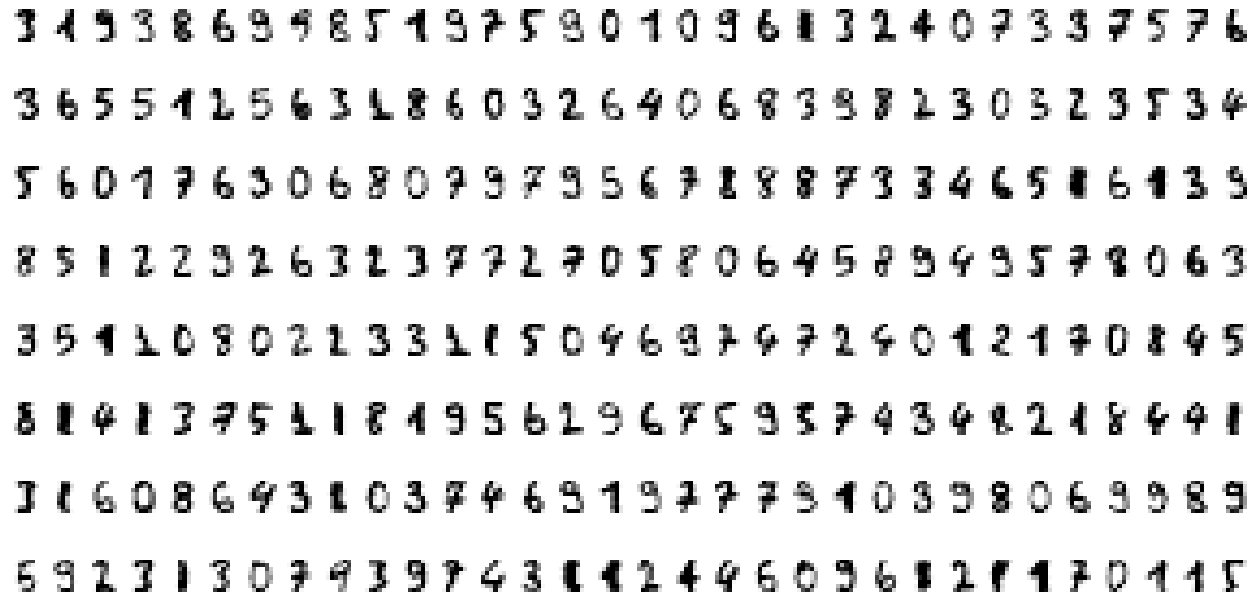

In [104]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

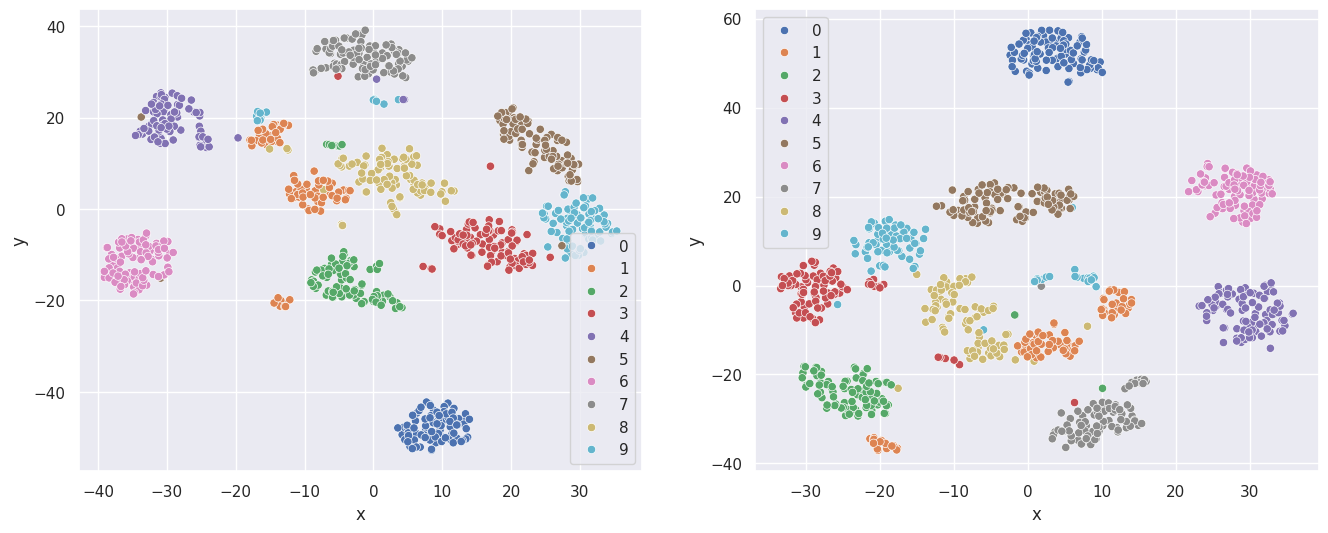

In [105]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    df = pd.DataFrame(
        {
         'x':x[:,0],
         'y':x[:,1]
        }
        )
    sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue=y, 
        palette=categorical_colors)    

<Axes: title={'center': 'Frequencia das classes no conjunto de teste (899 amostras)'}, xlabel='labels', ylabel='counts'>

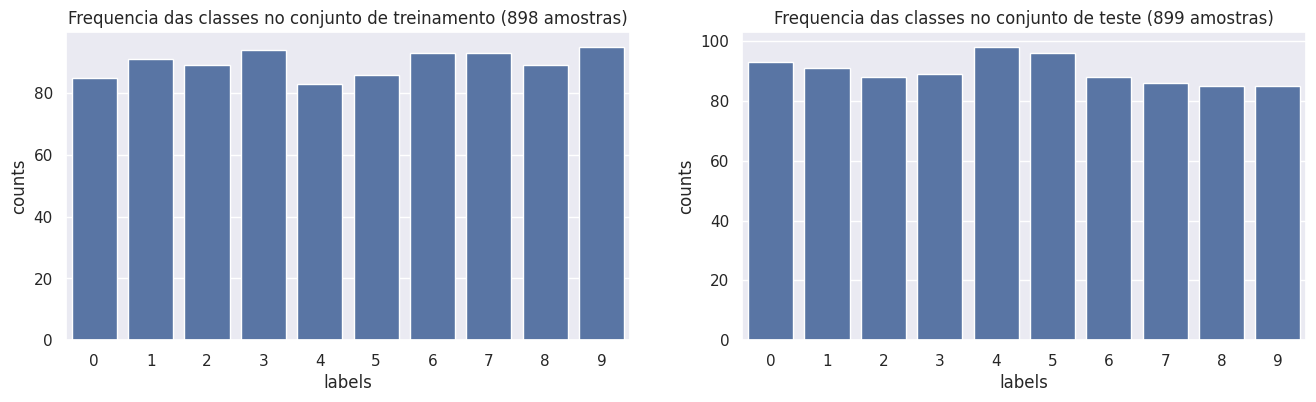

In [106]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
df = pd.DataFrame({'labels': labels, 'counts':counts})
sns.barplot(data=df, x='labels', y='counts')
# sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
df = pd.DataFrame({'labels': labels, 'counts':counts})
sns.barplot(data=df, x='labels', y='counts')
# sns.barplot(labels, counts)

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [112]:
x_train.shape

(898, 64)

In [113]:
from sklearn.svm import SVC

In [119]:
np.logspace(start=-10, stop=10, num=100)

array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
       2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07,
       1.70735265e-07, 2.71858824e-07, 4.32876128e-07, 6.89261210e-07,
       1.09749877e-06, 1.74752840e-06, 2.78255940e-06, 4.43062146e-06,
       7.05480231e-06, 1.12332403e-05, 1.78864953e-05, 2.84803587e-05,
       4.53487851e-05, 7.22080902e-05, 1.14975700e-04, 1.83073828e-04,
       2.91505306e-04, 4.64158883e-04, 7.39072203e-04, 1.17681195e-03,
       1.87381742e-03, 2.98364724e-03, 4.75081016e-03, 7.56463328e-03,
       1.20450354e-02, 1.91791026e-02, 3.05385551e-02, 4.86260158e-02,
       7.74263683e-02, 1.23284674e-01, 1.96304065e-01, 3.12571585e-01,
       4.97702356e-01, 7.92482898e-01, 1.26185688e+00, 2.00923300e+00,
       3.19926714e+00, 5.09413801e+00, 8.11130831e+00, 1.29154967e+01,
      

In [120]:
C_range = np.logspace(start=-10, stop=10, num=100)
param_grid = dict(C=C_range)

svc = SVC(kernel="linear", max_iter=100000)

grid = GridSearchCV(svc, 
                    param_grid, 
                    cv=10, 
                    scoring="accuracy",
                    verbose=1, 
                    n_jobs=n_jobs)

grid.fit(x_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=10, estimator=SVC(kernel='linear', max_iter=100000), n_jobs=6,
             param_grid={'C': array([1.00000000e-10, 1.59228279e-10, 2.53536449e-10, 4.03701726e-10,
       6.42807312e-10, 1.02353102e-09, 1.62975083e-09, 2.59502421e-09,
       4.13201240e-09, 6.57933225e-09, 1.04761575e-08, 1.66810054e-08,
       2.65608778e-08, 4.22924287e-08, 6.73415066e-08, 1.07226722e-07,
       1.70735265e-...
       2.25701972e+05, 3.59381366e+05, 5.72236766e+05, 9.11162756e+05,
       1.45082878e+06, 2.31012970e+06, 3.67837977e+06, 5.85702082e+06,
       9.32603347e+06, 1.48496826e+07, 2.36448941e+07, 3.76493581e+07,
       5.99484250e+07, 9.54548457e+07, 1.51991108e+08, 2.42012826e+08,
       3.85352859e+08, 6.13590727e+08, 9.77009957e+08, 1.55567614e+09,
       2.47707636e+09, 3.94420606e+09, 6.28029144e+09, 1.00000000e+10])},
             scoring='accuracy', verbose=1)

In [121]:
grid.cv_results_["mean_test_score"]

array([0.15153558, 0.15153558, 0.15153558, 0.15153558, 0.15153558,
       0.15153558, 0.15153558, 0.15153558, 0.15153558, 0.15153558,
       0.15153558, 0.15153558, 0.15153558, 0.15153558, 0.15153558,
       0.15153558, 0.15153558, 0.15153558, 0.15153558, 0.15153558,
       0.15153558, 0.15153558, 0.15153558, 0.15153558, 0.24287141,
       0.49220974, 0.78729089, 0.87967541, 0.9097628 , 0.92982522,
       0.94655431, 0.95545568, 0.95992509, 0.96549313, 0.97440699,
       0.97774032, 0.97997503, 0.97775281, 0.97440699, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665418,
       0.97665418, 0.97665418, 0.97665418, 0.97665418, 0.97665

In [122]:
grid.best_params_

{'C': 0.001873817422860383}

In [123]:
grid.best_estimator_

SVC(C=0.001873817422860383, kernel='linear', max_iter=100000)

In [ ]:
# best_svc = SVC(C=0.001873817422860383, kernel='linear', max_iter=100000)

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

In [133]:
from sklearn.metrics import (accuracy_score, 
                             confusion_matrix, 
                             classification_report)

In [129]:
best_svc = SVC(C=0.001873817422860383, kernel='linear', max_iter=100000)
best_svc.fit(x_train, y_train)

SVC(C=0.001873817422860383, kernel='linear', max_iter=100000)

In [134]:
y_pred_on_train = best_svc.predict(x_train)
y_pred_on_test = best_svc.predict(x_test)

print("Accuracy on train:", accuracy_score(y_train, y_pred_on_train))
print("Accuracy on test:", accuracy_score(y_test, y_pred_on_test))
print()
print("Confusion matrix on test:")
print(confusion_matrix(y_test, y_pred_on_test))
print()
print(classification_report(y_test, y_pred_on_test))

Accuracy on train: 0.9933184855233853
Accuracy on test: 0.9721913236929922

Confusion matrix on test:
[[92  0  0  0  1  0  0  0  0  0]
 [ 0 91  0  0  0  0  0  0  0  0]
 [ 0  0 88  0  0  0  0  0  0  0]
 [ 0  0  1 87  0  0  0  0  0  1]
 [ 0  0  0  0 98  0  0  0  0  0]
 [ 0  1  0  0  0 95  0  0  0  0]
 [ 2  1  0  0  0  0 85  0  0  0]
 [ 0  0  0  1  2  5  0 77  0  1]
 [ 0  2  1  2  0  1  0  0 79  0]
 [ 0  1  0  0  0  1  0  0  1 82]]

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        93
           1       0.95      1.00      0.97        91
           2       0.98      1.00      0.99        88
           3       0.97      0.98      0.97        89
           4       0.97      1.00      0.98        98
           5       0.93      0.99      0.96        96
           6       1.00      0.97      0.98        88
           7       1.00      0.90      0.94        86
           8       0.99      0.93      0.96        85
           9       0.98  

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [137]:
C_range = np.logspace(start=-10, stop=5, num=20)
gamma_range = np.logspace(start=-9, stop=3, num=8)
param_grid = dict(C=C_range, gamma=gamma_range)

svc = SVC(kernel="rbf", max_iter=100000)

grid = GridSearchCV(svc, 
                    param_grid, 
                    cv=10, 
                    scoring="accuracy",
                    verbose=1, 
                    n_jobs=n_jobs)

grid.fit(x_train, y_train)

print(grid.best_params_)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
{'C': 11.288378916846883, 'gamma': 0.0001389495494373136}


In [139]:
# best_svc_with_grid = SVC(kernel="rbf",
#                          C=11.288378916846883, 
#                          gamma=0.0001389495494373136,
#                          max_iter=100000).fit(x_train, y_train)

**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [140]:
from sklearn.model_selection import RandomizedSearchCV

In [141]:
5 * 15 * 10

750

In [142]:
C_range = np.logspace(start=-10, stop=5, num=50)
gamma_range = np.logspace(start=-9, stop=3, num=15)
param_dist = dict(C=C_range, gamma=gamma_range)

svc = SVC(kernel="rbf", max_iter=100000)
rand = RandomizedSearchCV(svc, 
                          param_dist, 
                          cv=10, 
                          scoring="accuracy", 
                          n_iter=25, 
                          random_state=5)
rand.fit(x_train, y_train)


print(rand.best_params_)
print(rand.best_estimator_)

{'gamma': 0.0001389495494373136, 'C': 24420.53094548655}
SVC(C=24420.53094548655, gamma=0.0001389495494373136, max_iter=100000)


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

In [144]:
best_svc_with_grid = SVC(kernel="rbf",
                         C=11.288378916846883, 
                         gamma=0.0001389495494373136,
                         max_iter=100000).fit(x_train, y_train)

In [143]:
best_svc_with_random = SVC(kernel="rbf",
                           C=24420.53094548655, 
                           gamma=0.0001389495494373136, 
                           max_iter=100000).fit(x_train, y_train)

In [148]:
# Predições com GridSearch
print("################ GRID SEARCH ################")
y_pred_on_train = best_svc_with_grid.predict(x_train)
y_pred_on_test = best_svc_with_grid.predict(x_test)

print("Accuracy on train:", accuracy_score(y_train, y_pred_on_train))
print("Accuracy on test:", accuracy_score(y_test, y_pred_on_test))
print()
print("Confusion matrix on test:")
print(confusion_matrix(y_test, y_pred_on_test))

# Predições com Random
print()
print("################ RANDOM SEARCH ################")
y_pred_on_train = best_svc_with_random.predict(x_train)
y_pred_on_test = best_svc_with_random.predict(x_test)

print("Accuracy on train:", accuracy_score(y_train, y_pred_on_train))
print("Accuracy on test:", accuracy_score(y_test, y_pred_on_test))
print()
print("Confusion matrix on test:")
print(confusion_matrix(y_test, y_pred_on_test))


# Dentre os modelos treinados com busca Grid ou busca Random, o que se saiu
# melhor sobre o conjunto de treino foi o melhor modelo retornado pela busca
# GridSearch. Tal fato pode estar relacionado à busca ser mais exaustiva

################ GRID SEARCH ################
Accuracy on train: 1.0
Accuracy on test: 0.982202447163515

Confusion matrix on test:
[[92  0  0  0  1  0  0  0  0  0]
 [ 0 91  0  0  0  0  0  0  0  0]
 [ 0  0 88  0  0  0  0  0  0  0]
 [ 0  0  1 88  0  0  0  0  0  0]
 [ 0  1  0  0 97  0  0  0  0  0]
 [ 0  1  0  0  0 95  0  0  0  0]
 [ 0  0  0  0  0  1 87  0  0  0]
 [ 0  0  0  0  2  2  0 81  0  1]
 [ 0  2  1  1  0  1  0  0 80  0]
 [ 0  0  0  0  0  0  0  0  1 84]]

################ RANDOM SEARCH ################
Accuracy on train: 1.0
Accuracy on test: 0.978865406006674

Confusion matrix on test:
[[92  0  0  0  1  0  0  0  0  0]
 [ 0 91  0  0  0  0  0  0  0  0]
 [ 0  0 88  0  0  0  0  0  0  0]
 [ 0  0  0 88  0  0  0  0  1  0]
 [ 0  1  0  0 97  0  0  0  0  0]
 [ 0  1  0  0  0 95  0  0  0  0]
 [ 0  0  0  0  0  1 87  0  0  0]
 [ 0  0  0  0  2  2  0 81  0  1]
 [ 0  2  1  1  0  1  0  0 80  0]
 [ 0  1  0  0  0  1  0  0  2 81]]
